## Finding the center of a circle given a Partial image of its Border



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize 
from statsmodels.base.model import GenericLikelihoodModel

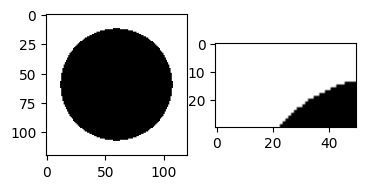

In [2]:
# Genero matriz con circulo 

n = 120
l = 10
R = 8

X, Y = np.meshgrid(np.linspace(-l,l,n), np.linspace(-l,l,n))
objeto = 1*(X**2 + Y**2 > R**2)

# Hago el crop
# Imagen = objeto[150:400, 0:150]
# Imagen = objeto[0:400, 0:550]
# Imagen = objeto[0:600, 0:150]
Imagen = objeto[0:30, 0:50]

plt.figure(figsize = [4, 10])
plt.subplot(1,2,1)
plt.imshow(objeto, cmap = 'gray')
plt.subplot(1,2,2)
plt.imshow(Imagen, cmap = 'gray')

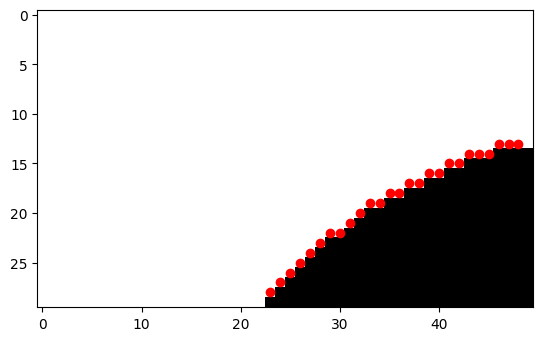

In [36]:
def search_border(fig):
    # Si siempre me muevo a la parte de arriba o abajo del circulo
    # podría servir
    x = np.asarray([])
    y = np.asarray([])
    for i,j in enumerate(fig):
        for k,l in enumerate(j):
            if fig[i, k]:            
                x = np.append(x, k)
                y = np.append(y, i)
                break

    if len(x) == 0 and len(y) == 0:
        print('No hay circulo')
        return None, None
    return x, y

def search_border2(fig):
    # Da problemas si el padding corta el circulo 
    # fig = np.pad(fig, [(1, 1), (1, 1)], mode='constant')

    # Puedo implementarlo desde abajo y desde arriba??
    x = np.asarray([])
    y = np.asarray([])
    for i,j in enumerate(fig[1:-1]):
        for k,l in enumerate(j[1:-1]):
            if fig[i, k] != fig[i, k+1] or fig[i, k] != fig[i+1, k]:            
                x = np.append(x, k)
                y = np.append(y, i)
    return x,y

def search_border3(fig):
    # Defino frontera
    y_max , x_max = np.asarray(fig.shape) - 1

    # Desplazamientos en las 4 direcciones principales
    up    = np.roll(fig, shift=-1, axis=0)
    down  = np.roll(fig, shift=1, axis=0)
    left  = np.roll(fig, shift=1, axis=1)
    right = np.roll(fig, shift=-1, axis=1)

    # Detectar bordes: puntos donde hay un 1 y algún vecino es 0
    border_mask = (fig == 1) & ((up == 0) | (down == 0) | (left == 0) | (right == 0))

    # Obtener coordenadas de los bordes
    y, x = np.where(border_mask)

    # Quito elementos de los bordes de imagen
    index_x = np.copy([i for i, xx in enumerate(x) if (xx <= 1 or xx >= x_max)])
    if len(index_x) != 0:
        y = np.delete(y, index_x)
        x = np.delete(x, index_x)

    index_y = np.copy([i for i, xx in enumerate(y) if (xx <= 1 or xx >= y_max)])
    if len(index_y) != 0:
        y = np.delete(y, index_y)
        x = np.delete(x, index_y)

    return x, y
                

x, y  = search_border3(Imagen)


# minimize(circle, x, y, args=(np.mean(x), np.mean(y), y.max - y.min))

plt.plot(x, y, 'ro') 
plt.imshow(Imagen, cmap = 'gray')
plt.show()





In [37]:
a = np.array([0,0,0,0,1,1,1,0,0,0,1])

print(np.roll(a,2))

[0 1 0 0 0 0 1 1 1 0 0]


CHI2:  [14251.46153846]
CHI2:  [14169.54528846]
CHI2:  [14228.46913462]
CHI2:  [15917.08653846]
CHI2:  [12620.46047009]
CHI2:  [11059.05288462]
CHI2:  [11970.51282051]
CHI2:  [10429.346599]
CHI2:  [8373.44849359]
CHI2:  [7126.97127137]
CHI2:  [4439.88661243]
CHI2:  [4622.4364497]
CHI2:  [3661.30038535]
CHI2:  [6590.0561144]
CHI2:  [3046.28417353]
CHI2:  [6306.62370964]
CHI2:  [3490.6372783]
CHI2:  [7894.11069219]
CHI2:  [3160.76172807]
CHI2:  [2616.85909116]
CHI2:  [3529.58442284]
CHI2:  [2371.16807634]
CHI2:  [2523.72416344]
CHI2:  [3623.95620749]
CHI2:  [2687.69259932]
CHI2:  [2089.20181404]
CHI2:  [2216.97410875]
CHI2:  [1685.36904741]
CHI2:  [1593.76454674]
CHI2:  [2219.13219544]
CHI2:  [1321.27387818]
CHI2:  [1434.46028318]
CHI2:  [2351.12980729]
CHI2:  [1675.07299583]
CHI2:  [1416.29688222]
CHI2:  [2283.8304722]
CHI2:  [1350.48409228]
CHI2:  [1605.31421738]
CHI2:  [1343.90046048]
CHI2:  [1712.3944088]
CHI2:  [1308.25501259]
CHI2:  [1349.8351923]
CHI2:  [1312.50171073]
CHI2:  [134

c:\Users\Raúl\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:2748: UserWarning: df_model + k_constant + k_extra differs from k_params
  warnings.warn("df_model + k_constant + k_extra "
c:\Users\Raúl\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:2752: UserWarning: df_resid differs from nobs - k_params
  warnings.warn("df_resid differs from nobs - k_params")


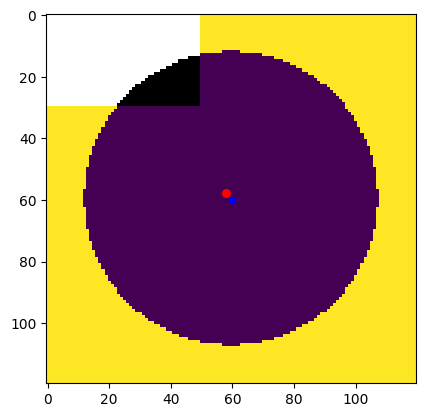

In [44]:

class CircleFit(GenericLikelihoodModel):
    """
    Clase Likelihood para crear modelos a partir de los puntos (x, y)
    del borde de un círculo y obtener mediante una minimización la posición
    del centro (x_c, y_c) y el radio r del círculo que mejor se ajusta a los datos.
    """

    def __init__(self, exog, endog, **kwds):
        """
        exog (array):  X, coordenadas x de los puntos del borde del círculo
        endog (array): Y, coordenadas y de los puntos del borde del círculo
        """
        self.n = int(len(exog))
        
        self.exog = np.asarray(exog)
        self.endog = np.asarray(endog)
        # Se dan valores iniciales razonables a los parámetros
        self.a = np.mean(exog)  # Posición centro en x
        self.b = np.mean(endog)  # Posición centro en y
        self.r = (np.max([(max(x)-min(x)), (max(y)-min(y))]))  # Radio círculo

        super(CircleFit, self).__init__(endog, exog, **kwds)  


    def loglike(self, params):
        #  Se actualizan los parámetros
        self.a = params[0]
        self.b = params[1]
        self.r = params[2]

        chi2 = 0.0

        for i in range(0, self.n):
            chi2 += np.abs(((self.exog[i]-self.a)**2 + (self.endog[i]-self.b)**2 - self.r**2))
        print('CHI2: ', chi2)

        return -chi2

    def fit(self, start_params=None, method='nm', maxiter=10000, **kwargs):

        if start_params is None:
            start_params =  [self.a, self.b, self.r]
        return super(CircleFit, self).fit(start_params=start_params, method=method, maxiter=maxiter, **kwargs)
    


cal = CircleFit(x, y)

results = cal.fit()    

print(results.summary())

print(results.params)

a, b, r = results.params

# plt.scatter(a,b, s = 30, c = 'r')   
 
plt.scatter(int(n/2), int(n/2), s = 20, c = 'b')
plt.imshow(objeto)   
plt.imshow(Imagen, cmap = 'gray')   
plt.scatter(a,b, s = 30, c = 'r')   
plt.show()

In [14]:
import cv2

from matplotlib.image import imread # leer imagenes
import matplotlib.pyplot as plt
import numpy as np


from skimage import feature



def search_border4(fig):
    
    plt.imshow(fig)


    fig = fig.astype('float32')  

    bordeCanny = cv2.Canny(np.uint8(fig), 100, 200)

    plt.imshow(fig)
    plt.show()
    print(bordeCanny.shape)
    plt.imshow(bordeCanny, cmap ='gray') 
    plt.show()


def edges(img):
    
    img = Image.open(img)
    img.convert('L')
    array = np.array(img)
    out = np.uint8(feature.canny(array, sigma=1, ) * 255)
    return Image.fromarray(out,mode='L')


fig = imread('./fiducial_test2.png')


# search_border4(fig)
# edges(fig)


# minimize(circle, x, y, args=(np.mean(x), np.mean(y), y.max - y.min))

# plt.plot(x, y, 'ro') 
# plt.imshow(Imagen, cmap = 'gray')
# plt.show()


ModuleNotFoundError: No module named 'skimage'